In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [2]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar_df.head()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,test_set
0,0,2,1,3,0,2,0,100,2,0,0,4,2,4,1.302547e+05,0,1,0,0,1,0,0,0,-1,0
1,0,1,0,4,0,4,0,0,3,1,0,1,4,4,0.000000e+00,0,1,1,1,2,1,1,1,0,1
2,0,1,0,4,1,4,0,100,3,1,0,1,4,6,2.581306e+05,12925040,3,1,0,2,1,1,1,0,1
3,0,3,1,3,0,4,0,0,2,0,0,3,3,5,1.341009e+06,0,3,1,0,1,0,0,0,-1,0
4,0,1,0,1,0,1,0,100,1,0,0,1,1,1,5.240306e+05,1209410,1,0,0,2,0,0,0,-1,0


In [3]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [4]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [5]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_final_test = final_test_df.iloc[:, 0]

In [6]:
# data noise 발생시킨다고 판단한 변수, feature importances=0 삭제
train_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'acc_type1',
       'insurance_site_aid_YN', 'police_site_aid_YN', 'total_prsn_cnt'],
      dtype='object')

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train_df.values, i) for i in range(train_df.shape[1])]
vif["features"] = train_df.columns
vif

,VIF Factor,features
0,1.004049,fraud_YN
1,5.362191,car_model
2,5.444233,age_group
3,5.757838,cumulative_use_count
4,6.514144,pf_type
5,6.283298,start_hour
6,4.407132,duration
7,4.788582,accident_hour
8,1.494093,repair_cost
9,1.197566,insure_cost


In [8]:
# VIF 10이상인 변수 제거
train_df.drop(columns=['police_site_aid_YN', 'acc_type1'], inplace=True)
train_df.columns

Index(['fraud_YN', 'car_model', 'age_group', 'cumulative_use_count', 'pf_type',
       'start_hour', 'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'repair_cnt', 'insurance_site_aid_YN',
       'total_prsn_cnt'],
      dtype='object')

In [9]:
# 학습해야 할 train 세트 - 타겟변수와 피쳐 분리
X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

X.shape, y.shape

((12879, 14), (12879,))

In [10]:
train_df.tail()

,fraud_YN,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt
12874,0,2,3,4,1,4,1,4,667293.0870,0,0,0,1,0,-1
12875,0,2,2,2,2,1,1,1,0.0000,0,1,1,1,0,-1
12876,0,2,2,4,1,5,2,6,618439.4418,0,2,1,1,0,-1
12877,0,2,2,2,2,6,1,2,0.0000,0,4,1,1,0,-1
12878,0,2,2,1,1,6,5,6,391560.2156,1188750,2,0,1,0,-1


In [11]:
train_df = pd.get_dummies(train_df, columns=['car_model', 'age_group', 'pf_type', 'start_hour', 'duration', 'accident_hour', 'accident_location', 'total_prsn_cnt'])

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12879 entries, 0 to 12878
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               12879 non-null  int64  
 1   cumulative_use_count   12879 non-null  int64  
 2   repair_cost            12879 non-null  float64
 3   insure_cost            12879 non-null  int64  
 4   car_part1              12879 non-null  int64  
 5   repair_cnt             12879 non-null  int64  
 6   insurance_site_aid_YN  12879 non-null  int64  
 7   car_model_1            12879 non-null  uint8  
 8   car_model_2            12879 non-null  uint8  
 9   car_model_3            12879 non-null  uint8  
 10  car_model_4            12879 non-null  uint8  
 11  car_model_5            12879 non-null  uint8  
 12  age_group_1            12879 non-null  uint8  
 13  age_group_2            12879 non-null  uint8  
 14  age_group_3            12879 non-null  uint8  
 15  ag

### 1. Original Data

In [13]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [14]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([8991,   24]))

In [15]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) *100

0.26622296173044924

In [16]:
tmp = np.unique(y_test, return_counts=True)[1]
tmp[1]/len(y_test) *100

0.2587991718426501

In [17]:
# 성능지표 반환 함수 생성
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [18]:
# confusion_matrix 생성함수
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    return confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

In [19]:
# 모델과 데이터를 주면 confusion matrix를 출력하는 함수
def get_confusion(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)    
    return print_clf_eval(y_test, pred)

In [20]:
# 다수의 모델 confusin matrix 정리해서 DataFrame으로 반환
def get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['f0p0', 'fo0p1', 'f1p0', 'f1p1']
    tmp =[]
    
    for model in models:
        tmp.append(get_confusion(model, X_train, y_train, X_test, y_test))
    
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

### 분류모델 
- 1. Logistic Regression
- 2. Decision Tree
- 3. Random Forest
- 4. LightGBM
- 5. SVM

In [21]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

(3854, 0, 10, 0)

In [22]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

(3854, 0, 10, 0)

In [23]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=300)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

(3854, 0, 10, 0)

In [24]:
# lgbm
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

(3854, 0, 10, 0)

In [25]:
# svm
from sklearn import svm

svm_clf = svm.SVC(probability=True)
svm_clf.fit(X_train, y_train)
svm_pred= svm_clf.predict(X_test)

print_clf_eval(y_test, svm_pred)

(3854, 0, 10, 0)

In [26]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [27]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [28]:
# 5개의 분류모델 표로 정리
import time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train, y_train, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  4.387202262878418


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
DecisionTree,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
RandomForest,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
LightGBM,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0
SVM,0.997412,0.0,0.0,0.0,0.5,3854,0,10,0


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  113.06332492828369


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.804089,0.005298,0.4,0.010458,0.602569,3103,751,6,4
DecisionTree,0.564700,0.003563,0.6,0.007084,0.582304,2176,1678,4,6
RandomForest,0.995083,0.000000,0.0,0.000000,0.498832,3845,9,10,0
LightGBM,0.994306,0.000000,0.0,0.000000,0.498443,3842,12,10,0
SVM,0.736542,0.004912,0.5,0.009728,0.618578,2841,1013,5,5


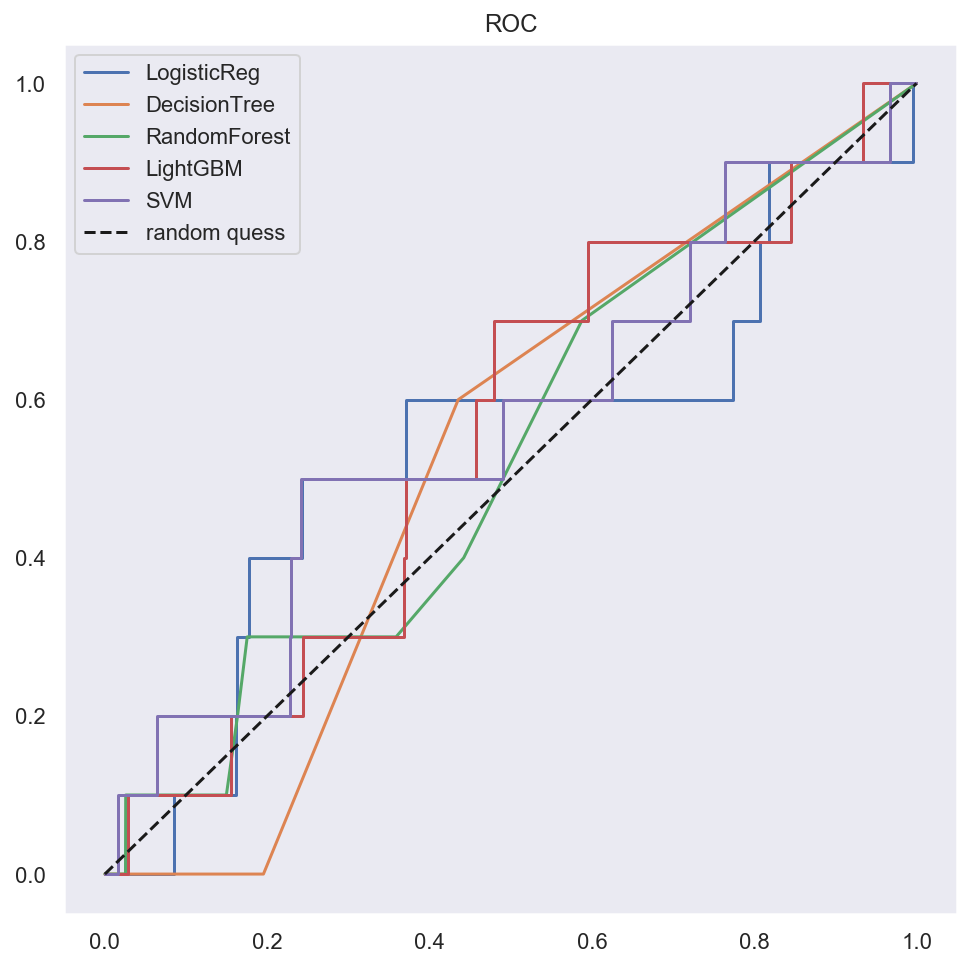

In [33]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 2. StandardScale to sequential features

''

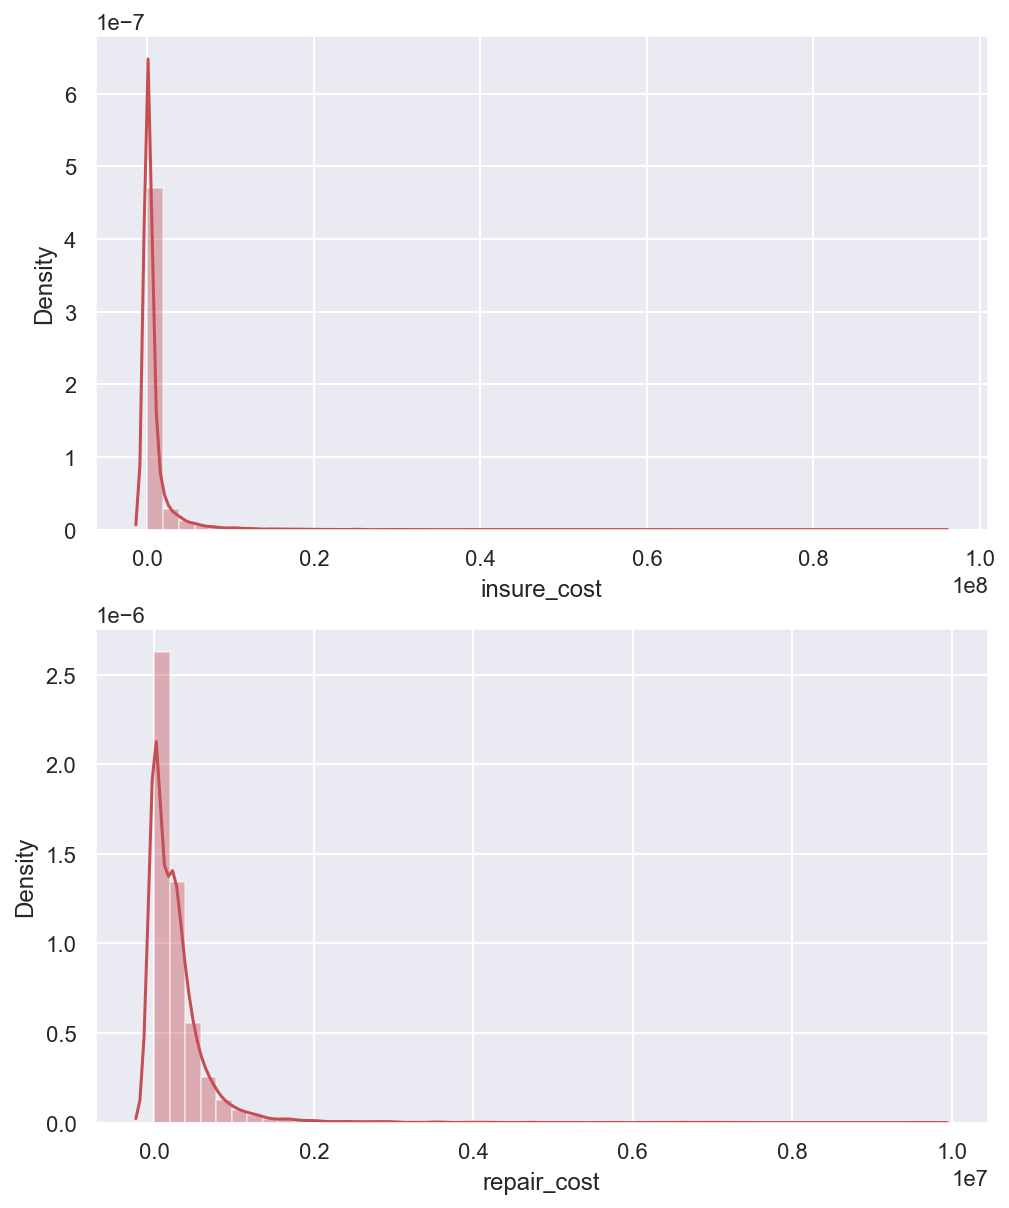

In [34]:
# 연속형 변수는 2개, 분포를 확인해보자
f, ax = plt.subplots(2, 1, figsize = (8, 10))

sns.distplot(train_df["insure_cost"], color="r", ax = ax[0])
sns.distplot(train_df["repair_cost"], color="r", ax = ax[1])
;
# 한쪽으로 매우 치우쳐져있다 -> 표준화

In [35]:
# train_df 에서 연속형 변수 가져와서 scaled feature 만들고
# target feature 및 original 연속형변수 삭제
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(train_df['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(train_df['repair_cost'].values.reshape(-1,1))

X_ss = train_df.drop(['fraud_YN', 'insure_cost', 'repair_cost'], axis=1) 
X_ss['scaled_insure_cost'] = insure_n
X_ss['scaled_repair_cost'] = repair_n

X_ss.head()

,cumulative_use_count,car_part1,repair_cnt,insurance_site_aid_YN,car_model_1,car_model_2,car_model_3,car_model_4,car_model_5,age_group_1,age_group_2,age_group_3,...,accident_location_3,accident_location_4,accident_location_5,total_prsn_cnt_-1,total_prsn_cnt_0,total_prsn_cnt_1,total_prsn_cnt_2,total_prsn_cnt_3,total_prsn_cnt_4,total_prsn_cnt_5,scaled_insure_cost,scaled_repair_cost
0,2,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,-0.273447,-0.296588
1,4,1,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0,-0.273447,2.047627
2,1,0,2,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0.121310,0.465826
3,4,0,1,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0.123879,-0.548781
4,4,0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,-0.273447,-0.548781


In [36]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, random_state=13, stratify=y)

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  18.37438416481018


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997153,0.000000,0.0,0.000000,0.499870,3853,1,10,0
DecisionTree,0.624224,0.004127,0.6,0.008197,0.612143,2406,1448,4,6
RandomForest,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0
LightGBM,0.997153,0.000000,0.0,0.000000,0.499870,3853,1,10,0
SVM,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0


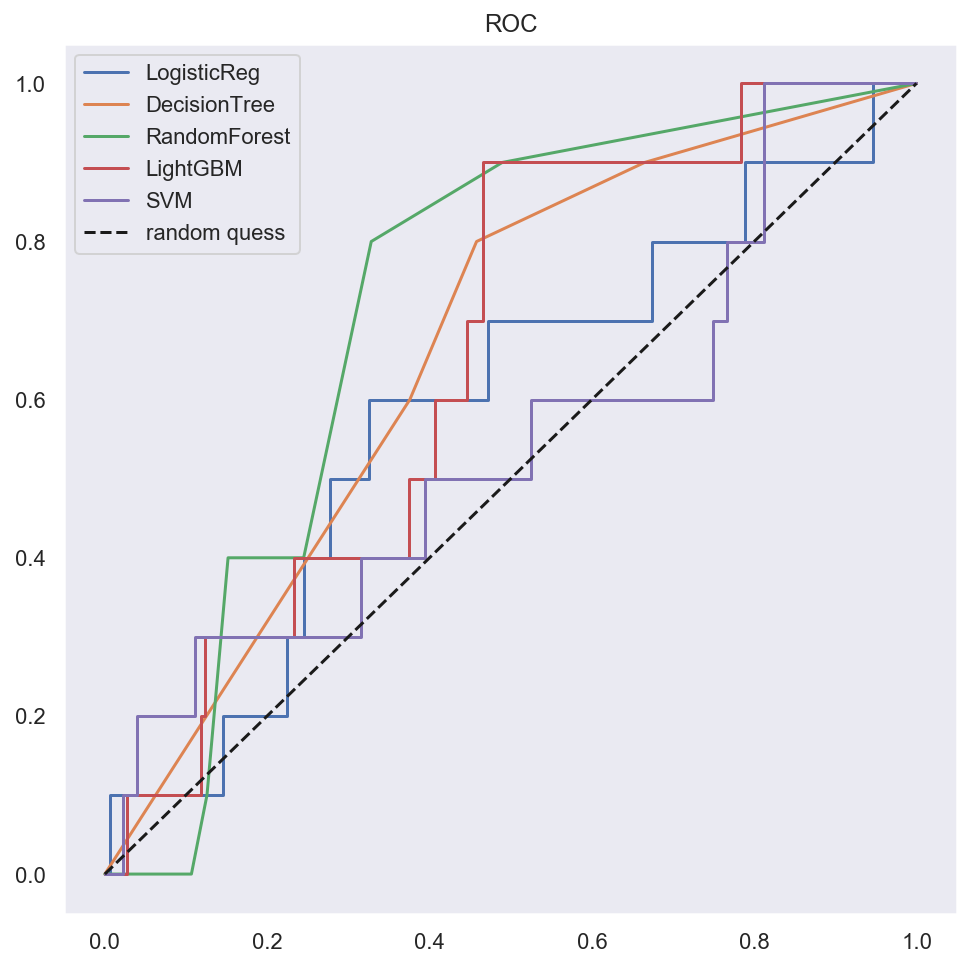

In [38]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

### 3. log scale

In [39]:
insure_log = np.log1p(train_df['insure_cost'])
repair_log = np.log1p(train_df['repair_cost'])

X_ls= train_df.drop(['insure_cost', 'repair_cost', 'fraud_YN'], axis=1) 
X_ls['scaled_insure_cost'] = insure_log
X_ls['scaled_repair_cost'] = repair_log

X_ls.head()

,cumulative_use_count,car_part1,repair_cnt,insurance_site_aid_YN,car_model_1,car_model_2,car_model_3,car_model_4,car_model_5,age_group_1,age_group_2,age_group_3,...,accident_location_3,accident_location_4,accident_location_5,total_prsn_cnt_-1,total_prsn_cnt_0,total_prsn_cnt_1,total_prsn_cnt_2,total_prsn_cnt_3,total_prsn_cnt_4,total_prsn_cnt_5,scaled_insure_cost,scaled_repair_cost
0,2,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0.000000,11.777255
1,4,1,1,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0,0.000000,14.108934
2,1,0,2,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,14.005644,13.169307
3,4,0,1,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,14.012130,0.000000
4,4,0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0.000000,0.000000


In [40]:
# train_set 내에서 train / test(validation) set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.3, random_state=13, stratify=y)

In [41]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  46.3895468711853


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0
DecisionTree,0.618789,0.003394,0.5,0.006743,0.559549,2386,1468,5,5
RandomForest,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0
LightGBM,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0
SVM,0.997412,0.000000,0.0,0.000000,0.500000,3854,0,10,0


### 4. remove outlier

In [71]:
# 사기 데이터라 비용이 fraud가 이상치에서 발생했나 보려고 fraud YN 에 따라 plot 따로 그려봄
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['insure_cost'], name = 'insure_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['insure_cost'], name = 'insure_cost_1'))

fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==0]['repair_cost'], name = 'repair_cost_0'))
fig.add_trace(go.Box(y = train_df[train_df['fraud_YN']==1]['repair_cost'], name = 'repair_cost_1'))

# 이상치가 fraud data에 영향을 끼칠것 같지는 않음

In [93]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [94]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)

Int64Index([92, 342, 3773], dtype='int64')

In [95]:
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)

Int64Index([12, 4576], dtype='int64')

In [96]:
# 이상치 제거, 중복 index 있으면 unique하게 남겨두기
outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5)) + list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
outlier_index = set(outlier_index)

# origianl data 이상치 제거 
X_rmol = X.drop(outlier_index, axis=0)

# standard scaled data 이상치 제거 
X_ss_rmol = X_ss.drop(outlier_index, axis=0)

# log scaled data 이상치 제거
X_ls_rmol = X_ls.drop(outlier_index, axis=0)

# target 변수 이상치 제거 
y_rmol = y.drop(outlier_index, axis=0)

In [76]:
X_rmol.shape, X_ss_rmol.shape, X_ls_rmol.shape, y_rmol.shape

((10645, 14), (10645, 50), (10645, 50), (10645,))

In [97]:
# original 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [98]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  106.30740571022034


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.891535,0.000000,0.000000,0.000000,0.446809,3444,410,9,0
DecisionTree,0.758996,0.003233,0.333333,0.006403,0.546661,2929,925,6,3
RandomForest,0.996376,0.000000,0.000000,0.000000,0.499351,3849,5,9,0
LightGBM,0.995858,0.000000,0.000000,0.000000,0.499092,3847,7,9,0
SVM,0.227802,0.002676,0.888889,0.005335,0.557574,872,2982,1,8


In [99]:
# standard scale 이상치 제거

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_ss_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [101]:
# over sampling 
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'SVM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  17.591761350631714


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997670,0.00000,0.000000,0.000000,0.500000,3854,0,9,0
DecisionTree,0.563034,0.00296,0.555556,0.005889,0.559303,2170,1684,4,5
RandomForest,0.997670,0.00000,0.000000,0.000000,0.500000,3854,0,9,0
LightGBM,0.997411,0.00000,0.000000,0.000000,0.499870,3853,1,9,0
SVM,0.997670,0.00000,0.000000,0.000000,0.500000,3854,0,9,0


In [102]:
# log scale 이상치 제거
X_train, X_test, y_train, y_test = train_test_split(X_ls_rmol, y_rmol, test_size=0.3, random_state=13, stratify=y_rmol)

In [103]:
# over sampling 
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

start_time = time.time()
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
print('Fit time: ', time.time() - start_time)
results = pd.concat([performance, confusion_metrics], axis=1)
results

Fit time:  9.500925302505493


,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997670,0.000000,0.000000,0.00000,0.500000,3854,0,9,0
DecisionTree,0.624126,0.003441,0.555556,0.00684,0.589921,2406,1448,4,5
RandomForest,0.997670,0.000000,0.000000,0.00000,0.500000,3854,0,9,0
LightGBM,0.997670,0.000000,0.000000,0.00000,0.500000,3854,0,9,0


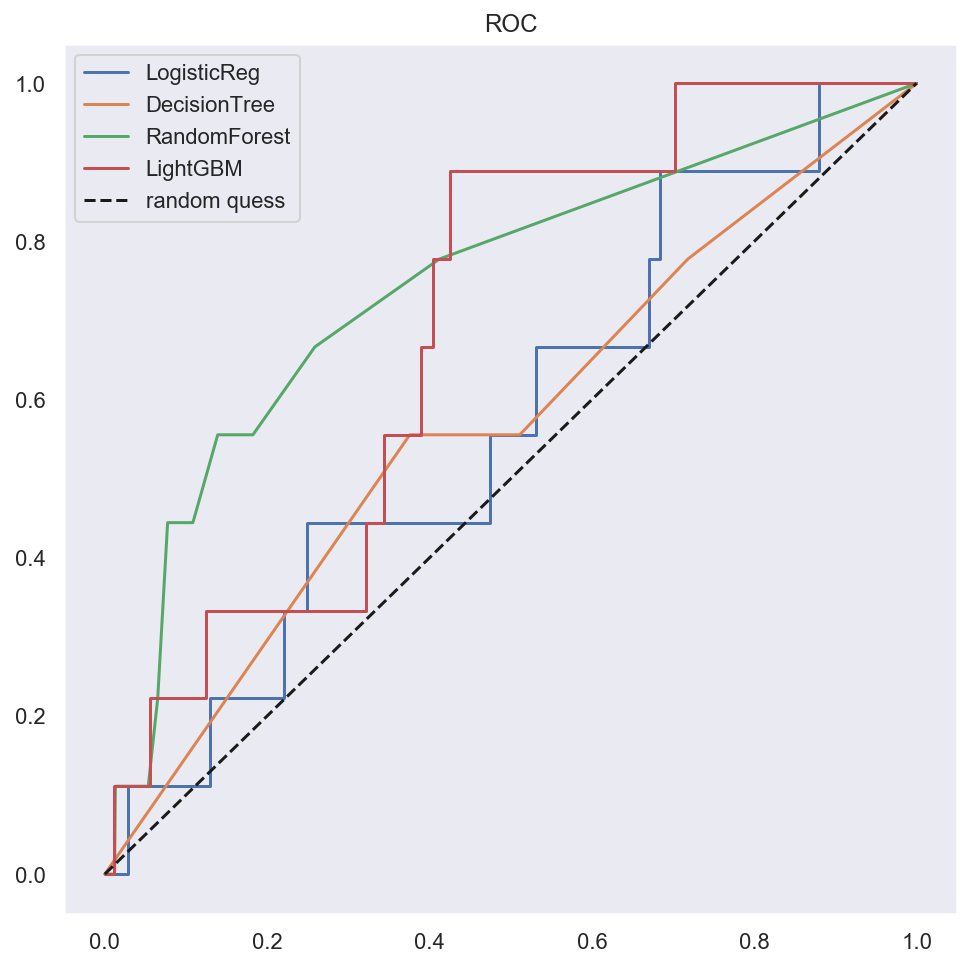

In [104]:
from sklearn.metrics import roc_curve

def draw_roc_curve(model, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))
    
    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label = model_names[model])
        
    plt.plot([0,1], [0,1], 'k--', label = 'random quess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

draw_roc_curve(models, model_names, X_test, y_test)   

In [1]:
########## final test data 적용 ##############

In [29]:
# 불필요한 변수 삭제
socar_del = socar_df.drop(columns=['sharing_type', 'has_previous_accident','b2b','accident_ratio','socarpass','socarsave', 'car_part2','police_site_aid_YN', 'acc_type1'])
socar_del.head()

,fraud_YN,car_model,age_group,cumulative_use_count,pf_type,start_hour,duration,accident_hour,repair_cost,insure_cost,accident_location,car_part1,repair_cnt,insurance_site_aid_YN,total_prsn_cnt,test_set
0,0,2,3,2,2,4,2,4,1.302547e+05,0,1,0,1,0,-1,0
1,0,1,4,4,3,1,4,4,0.000000e+00,0,1,1,2,1,0,1
2,0,1,4,4,3,1,4,6,2.581306e+05,12925040,3,1,2,1,0,1
3,0,3,3,4,2,3,3,5,1.341009e+06,0,3,1,1,0,-1,0
4,0,1,1,1,1,1,1,1,5.240306e+05,1209410,1,0,2,0,-1,0


In [30]:
socar_onehot = pd.get_dummies(socar_del, columns=['car_model', 'age_group', 'pf_type', 'start_hour', 'duration', 'accident_hour', 'accident_location', 'total_prsn_cnt'])

In [31]:
train_df = socar_onehot[socar_onehot.test_set == 0]
final_test_df = socar_onehot[socar_onehot.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

In [33]:
models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM']

performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results = pd.concat([performance, confusion_metrics], axis=1)
results

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.975969,0.0,0.0,0.0,0.489082,3046,68,7,0
DecisionTree,0.706504,0.0,0.0,0.0,0.354046,2205,909,7,0
RandomForest,0.997757,0.0,0.0,0.0,0.500000,3114,0,7,0
LightGBM,0.997757,0.0,0.0,0.0,0.500000,3114,0,7,0


In [34]:
# standard scale 

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
insure_n = scaler.fit_transform(socar_onehot['insure_cost'].values.reshape(-1,1))
repair_n = scaler.fit_transform(socar_onehot['repair_cost'].values.reshape(-1,1))

socar_ss_df = socar_onehot.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ss_df['scaled_insure_cost'] = insure_n
socar_ss_df['scaled_repair_cost'] = repair_n
socar_ss_df.tail()

,fraud_YN,cumulative_use_count,car_part1,repair_cnt,insurance_site_aid_YN,test_set,car_model_1,car_model_2,car_model_3,car_model_4,car_model_5,age_group_1,...,accident_location_3,accident_location_4,accident_location_5,total_prsn_cnt_-1,total_prsn_cnt_0,total_prsn_cnt_1,total_prsn_cnt_2,total_prsn_cnt_3,total_prsn_cnt_4,total_prsn_cnt_5,scaled_insure_cost,scaled_repair_cost
15995,0,2,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,-0.277737,-0.551069
15996,0,4,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,-0.277737,0.644681
15997,0,4,0,1,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,-0.277737,-0.551069
15998,0,2,1,1,0,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0,-0.277737,-0.551069
15999,0,1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0.106422,0.206011


In [36]:
train_df = socar_ss_df[socar_ss_df.test_set == 0]
final_test_df = socar_ss_df[socar_ss_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [37]:
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

X_train_over.shape, y_train_over.shape, X.shape, y.shape

((25690, 50), (25690,), (12879, 50), (12879,))

In [39]:
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results = pd.concat([performance, confusion_metrics], axis=1)
results

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
DecisionTree,0.467158,0.001805,0.428571,0.003595,0.447908,1455,1659,4,3
RandomForest,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
LightGBM,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0


In [40]:
insure_log = np.log1p(socar_onehot['insure_cost'])
repair_log = np.log1p(socar_onehot['repair_cost'])

socar_ls_df= socar_onehot.drop(['insure_cost', 'repair_cost'], axis=1) 
socar_ls_df['scaled_insure_cost'] = insure_log
socar_ls_df['scaled_repair_cost'] = repair_log

socar_ls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               16000 non-null  int64  
 1   cumulative_use_count   16000 non-null  int64  
 2   car_part1              16000 non-null  int64  
 3   repair_cnt             16000 non-null  int64  
 4   insurance_site_aid_YN  16000 non-null  int64  
 5   test_set               16000 non-null  int64  
 6   car_model_1            16000 non-null  uint8  
 7   car_model_2            16000 non-null  uint8  
 8   car_model_3            16000 non-null  uint8  
 9   car_model_4            16000 non-null  uint8  
 10  car_model_5            16000 non-null  uint8  
 11  age_group_1            16000 non-null  uint8  
 12  age_group_2            16000 non-null  uint8  
 13  age_group_3            16000 non-null  uint8  
 14  age_group_4            16000 non-null  uint8  
 15  ag

In [41]:
train_df = socar_ls_df[socar_ls_df.test_set == 0]
final_test_df = socar_ls_df[socar_ls_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [42]:
X_final_test = final_test_df.drop(columns=["fraud_YN"])
y_final_test = final_test_df["fraud_YN"]
X = train_df.drop(columns=["fraud_YN"])
y = train_df["fraud_YN"]

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_sample(X, y)

X_train_over.shape, y_train_over.shape, X.shape, y.shape

((25690, 50), (25690,), (12879, 50), (12879,))

In [44]:
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results = pd.concat([performance, confusion_metrics], axis=1)
results

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
DecisionTree,0.467158,0.001805,0.428571,0.003595,0.447908,1455,1659,4,3
RandomForest,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
LightGBM,0.997437,0.000000,0.000000,0.000000,0.499839,3113,1,7,0
